In [1]:
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import os

In [2]:
class Coordinate(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        mid_ch = max(8, in_ch // 2)

        self.h_pool = nn.AdaptiveAvgPool2d((1, None))
        self.h_conv = nn.Conv2d(in_ch, mid_ch, kernel_size=(1, 3), padding=(0, 1), bias=False)

        self.v_pool = nn.AdaptiveAvgPool2d((None, 1))
        self.v_conv = nn.Conv2d(in_ch, mid_ch, kernel_size=(3, 1), padding=(1, 0), bias=False)

        self.fuse = nn.Conv2d(mid_ch * 2, in_ch, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        shortcut = x
        h = self.h_conv(self.h_pool(x))
        v = self.v_conv(self.v_pool(x))

        h = nn.functional.interpolate(h, size=x.shape[2:], mode='bilinear', align_corners=False)
        v = nn.functional.interpolate(v, size=x.shape[2:], mode='bilinear', align_corners=False)

        att = torch.cat([h, v], dim=1) 
        att = self.fuse(att)            
        att = self.sigmoid(att)
        return x * att

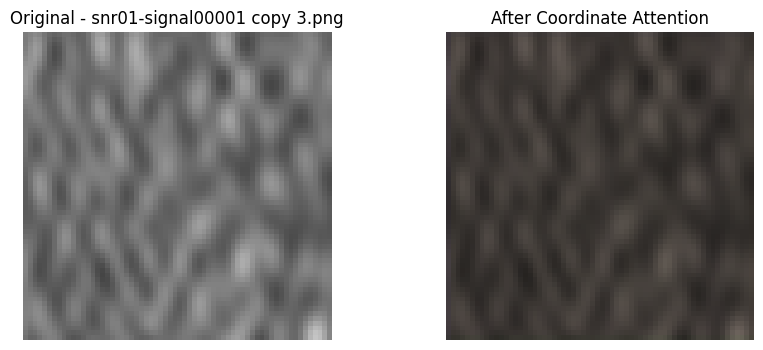

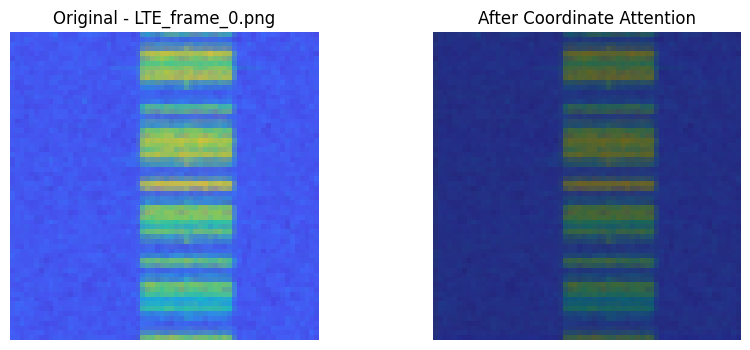

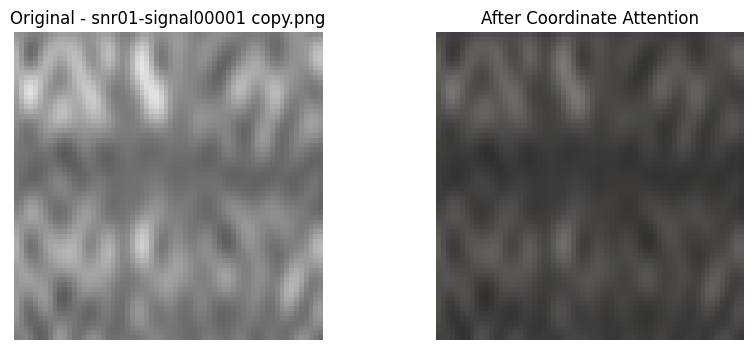

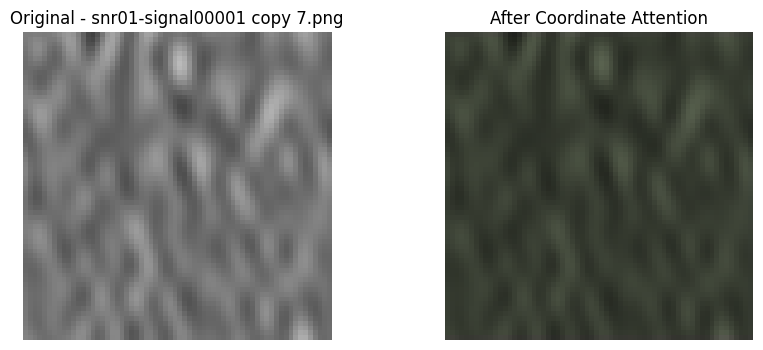

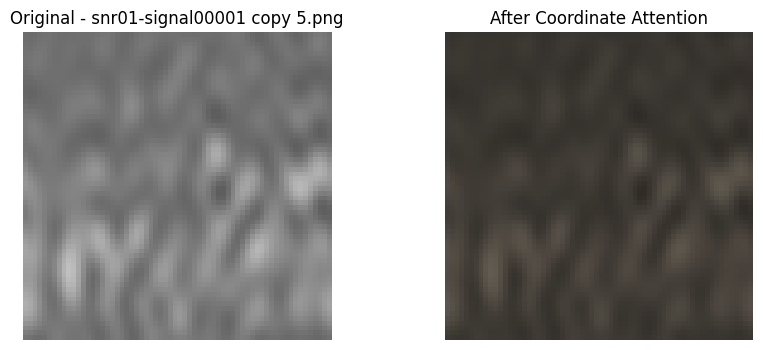

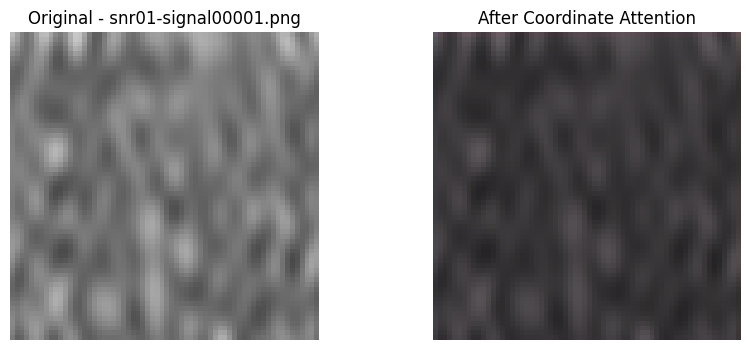

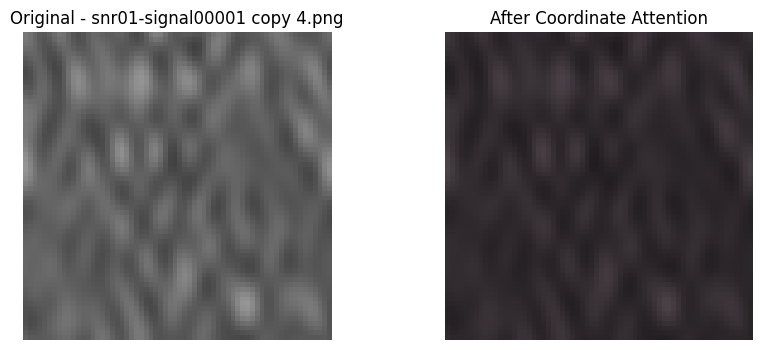

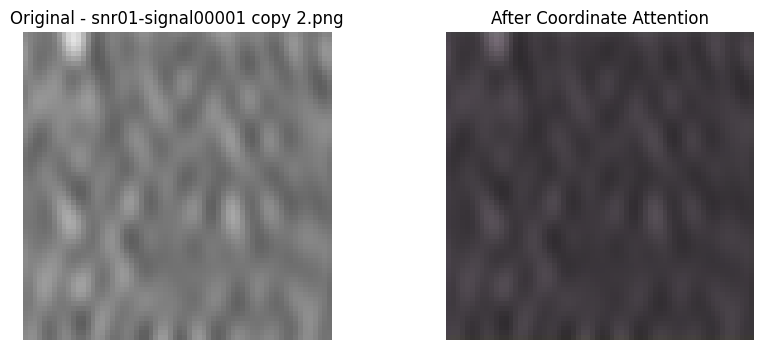

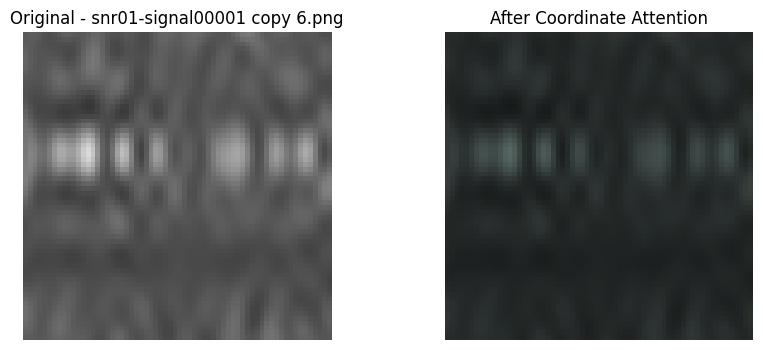

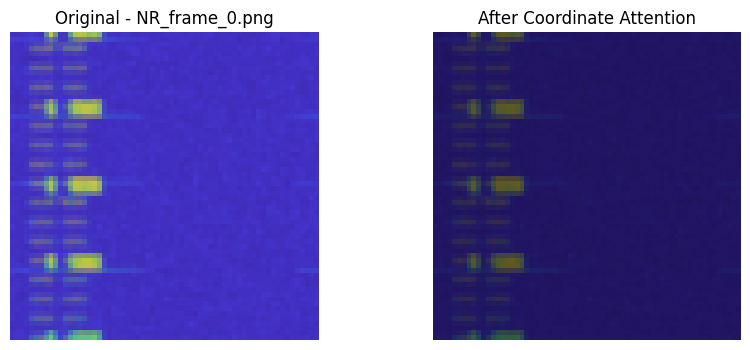

In [3]:
img_folder = '/home/vydat/Code/ML_AI/Source/img'

for img_name in os.listdir(img_folder):
    img_path = os.path.join(img_folder, img_name)
    
    if img_path.endswith(('.png', '.jpg', '.jpeg')): 
        image = Image.open(img_path).convert('RGB')

        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

        img_tensor = transform(image).unsqueeze(0)

        coordatt = Coordinate(3)
        coordatt.eval()

        with torch.no_grad():
            out_tensor = coordatt(img_tensor).squeeze().clamp(0, 1)

        def tensor_to_image(tensor):
            return tensor.permute(1, 2, 0).cpu().numpy()

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title(f'Original - {img_name}')
        plt.imshow(tensor_to_image(img_tensor.squeeze()))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f'After Coordinate Attention')
        plt.imshow(tensor_to_image(out_tensor))
        plt.axis('off')

        plt.show()